In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import cv2

In [2]:
class PatchEmbedding(layers.Layer):
    """
    Convert image into patches and embed them
    Key concept: ViT treats image as sequence of patches
    """
    def __init__(self, patch_size=16, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Conv2D to extract patches and embed them
        self.projection = layers.Conv2D(
            embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='valid'
        )

    def call(self, x):
        # x shape: (batch, height, width, channels)
        # After projection: (batch, num_patches_h, num_patches_w, embed_dim)
        patches = self.projection(x)

        # Reshape to sequence: (batch, num_patches, embed_dim)
        batch_size = tf.shape(patches)[0]
        patches = tf.reshape(patches, [batch_size, -1, self.embed_dim])

        return patches

In [3]:
class MultiHeadSelfAttention(layers.Layer):
    """
    Multi-head self-attention mechanism
    Core of transformer: patches can "attend" to each other
    """
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads
        )
        self.norm = layers.LayerNormalization()

    def call(self, x):
        # Self-attention: each patch attends to all patches
        attention_output = self.mha(x, x)  # query=key=value=x

        # Residual connection + normalization
        x = self.norm(x + attention_output)
        return x

In [4]:
class MLP(layers.Layer):
    """
    Simple MLP block (feed-forward network)
    """
    def __init__(self, embed_dim=64, mlp_dim=128):
        super().__init__()
        self.dense1 = layers.Dense(mlp_dim, activation='relu')
        self.dense2 = layers.Dense(embed_dim)
        self.norm = layers.LayerNormalization()

    def call(self, x):
        mlp_output = self.dense2(self.dense1(x))
        # Residual connection + normalization
        return self.norm(x + mlp_output)

In [5]:
class TransformerBlock(layers.Layer):
    """
    Complete Transformer block: Attention + MLP
    """
    def __init__(self, embed_dim=64, num_heads=4, mlp_dim=128):
        super().__init__()
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = MLP(embed_dim, mlp_dim)

    def call(self, x):
        x = self.attention(x)
        x = self.mlp(x)
        return x

In [6]:

class SimpleViT(tf.keras.Model):
    """
    Simple Vision Transformer for image classification
    """
    def __init__(self,
                 img_size=64,
                 patch_size=16,
                 num_classes=3,
                 embed_dim=64,
                 num_heads=4,
                 num_layers=2):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # 1. Patch embedding
        self.patch_embedding = PatchEmbedding(patch_size, embed_dim)

        # 2. Position embedding (learnable)
        self.position_embedding = self.add_weight(
            shape=(1, self.num_patches + 1, embed_dim),
            initializer='random_normal',
            trainable=True,
            name='position_embedding'
        )

        # 3. Class token (like BERT's [CLS] token)
        self.class_token = self.add_weight(
            shape=(1, 1, embed_dim),
            initializer='random_normal',
            trainable=True,
            name='class_token'
        )

        # 4. Transformer blocks
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, embed_dim * 2)
            for _ in range(num_layers)
        ]

        # 5. Classification head
        self.norm = layers.LayerNormalization()
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        batch_size = tf.shape(x)[0]

        # 1. Convert image to patches
        patches = self.patch_embedding(x)  # (batch, num_patches, embed_dim)

        # 2. Add class token
        class_tokens = tf.broadcast_to(
            self.class_token, [batch_size, 1, self.class_token.shape[-1]]
        )
        patches = tf.concat([class_tokens, patches], axis=1)

        # 3. Add position embeddings
        patches = patches + self.position_embedding

        # 4. Pass through transformer blocks
        for transformer in self.transformer_blocks:
            patches = transformer(patches)

        # 5. Use class token for classification
        class_token_final = patches[:, 0]  # First token is class token
        class_token_final = self.norm(class_token_final)

        # 6. Classify
        predictions = self.classifier(class_token_final)

        return predictions

In [7]:
def create_simple_shapes_dataset(num_samples=300, img_size=64):
    """
    Create simple dataset for ViT: circles, squares, triangles
    """
    images = []
    labels = []

    print(f"Creating {num_samples} images for ViT...")

    for i in range(num_samples):
        # Create blank image
        img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Choose shape type
        shape_type = i % 3  # 0=circle, 1=square, 2=triangle
        color = np.random.randint(100, 255, 3).tolist()

        if shape_type == 0:  # Circle
            center = (img_size//2, img_size//2)
            radius = np.random.randint(15, 25)
            cv2.circle(img, center, radius, color, -1)

        elif shape_type == 1:  # Square
            size = np.random.randint(20, 35)
            x1 = (img_size - size) // 2
            y1 = (img_size - size) // 2
            cv2.rectangle(img, (x1, y1), (x1+size, y1+size), color, -1)

        elif shape_type == 2:  # Triangle
            pts = np.array([
                [img_size//2, img_size//2 - 15],  # Top
                [img_size//2 - 15, img_size//2 + 15],  # Bottom left
                [img_size//2 + 15, img_size//2 + 15]   # Bottom right
            ], np.int32)
            cv2.fillPoly(img, [pts], color)

        images.append(img)
        labels.append(shape_type)

    # Convert and normalize
    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels, dtype=np.int32)

    print("Dataset created!")
    return images, labels

In [8]:
def visualize_patches(image, patch_size=16):
    """
    Visualize how ViT breaks image into patches
    """
    height, width = image.shape[:2]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Image with patch grid
    image_with_grid = image.copy()

    # Draw grid lines
    for i in range(0, height, patch_size):
        cv2.line(image_with_grid, (0, i), (width, i), (1, 1, 1), 1)
    for j in range(0, width, patch_size):
        cv2.line(image_with_grid, (j, 0), (j, height), (1, 1, 1), 1)

    axes[1].imshow(image_with_grid)
    axes[1].set_title(f'Patches ({patch_size}x{patch_size})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate number of patches
    num_patches = (height // patch_size) * (width // patch_size)
    print(f"Image divided into {num_patches} patches")

In [9]:
def show_attention_concept():
    """
    Visualize the attention mechanism concept
    """
    print("Vision Transformer Key Concepts:")
    print("=" * 40)
    print("1. IMAGE → PATCHES:")
    print("   • Split image into 16x16 patches")
    print("   • Each patch becomes a 'word' in transformer")
    print("   • Add position info so model knows where patches are")
    print("")
    print("2. SELF-ATTENTION:")
    print("   • Each patch can 'look at' all other patches")
    print("   • Learns relationships between distant parts of image")
    print("   • Unlike CNN: can connect far-apart regions directly")
    print("")
    print("3. CLASSIFICATION:")
    print("   • Add special [CLS] token at beginning")
    print("   • After attention, [CLS] token contains image info")
    print("   • Use [CLS] token for final classification")

In [12]:
def run_simple_vit_exercise():
    """
    Complete ViT exercise
    """
    print("=" * 50)
    print("SIMPLE VISION TRANSFORMER EXERCISE")
    print("=" * 50)

    # Step 1: Show concepts
    print("\n1. Understanding ViT concepts...")
    show_attention_concept()

    # Step 2: Create dataset
    print("\n2. Creating simple dataset...")
    images, labels = create_simple_shapes_dataset(num_samples=300, img_size=64)

    class_names = ['Circle', 'Square', 'Triangle']
    print(f"Dataset: {images.shape}, Classes: {class_names}")

    # Step 3: Visualize patches
    print("\n3. Visualizing how ViT sees images...")
    sample_image = images[0]
    visualize_patches(sample_image, patch_size=16)

    # Step 4: Show examples
    print("\n4. Showing dataset examples...")
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(images[i])
        axes[i].set_title(f'{class_names[labels[i]]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Step 5: Split data
    print("\n5. Splitting data...")
    split_idx = int(0.8 * len(images))
    train_images, test_images = images[:split_idx], images[split_idx:]
    train_labels, test_labels = labels[:split_idx], labels[split_idx:]

    print(f"Train: {len(train_images)}, Test: {len(test_images)}")

    # Step 6: Create ViT model
    print("\n6. Creating Vision Transformer...")
    vit_model = SimpleViT(
        img_size=64,
        patch_size=16,
        num_classes=3,
        embed_dim=64,
        num_heads=4,
        num_layers=2
    )

    vit_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Build model (needed for summary)
    vit_model.build(input_shape=(None, 64, 64, 3))
    print(f"ViT model created with {vit_model.count_params():,} parameters")

    # Step 7: Train model
    print("\n7. Training ViT model...")
    print("This might take a few minutes...")

    history = vit_model.fit(
        train_images, train_labels,
        batch_size=16,
        epochs=10,
        validation_data=(test_images, test_labels),
        verbose=1
    )

    # Step 8: Evaluate
    print("\n8. Testing ViT model...")
    test_loss, test_accuracy = vit_model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test accuracy: {test_accuracy:.3f}")

    # Step 9: Show predictions
    print("\n9. Showing ViT predictions...")
    predictions = vit_model.predict(test_images[:6])
    pred_classes = np.argmax(predictions, axis=1)

    fig, axes = plt.subplots(2, 6, figsize=(15, 6))

    for i in range(6):
        # Original
        axes[0, i].imshow(test_images[i])
        axes[0, i].set_title(f'True: {class_names[test_labels[i]]}')
        axes[0, i].axis('off')

        # Prediction confidence
        pred_probs = predictions[i]
        axes[1, i].bar(class_names, pred_probs)
        axes[1, i].set_title(f'Pred: {class_names[pred_classes[i]]}')
        axes[1, i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Step 10: Training history
    print("\n10. Training results...")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='Train Loss')
    plt.plot(history.history['val_loss'], 'r-', label='Val Loss')
    plt.title('ViT Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Train Acc')
    plt.plot(history.history['val_accuracy'], 'r-', label='Val Acc')
    plt.title('ViT Training Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


SIMPLE VISION TRANSFORMER EXERCISE

1. Understanding ViT concepts...
Vision Transformer Key Concepts:
1. IMAGE → PATCHES:
   • Split image into 16x16 patches
   • Each patch becomes a 'word' in transformer
   • Add position info so model knows where patches are

2. SELF-ATTENTION:
   • Each patch can 'look at' all other patches
   • Learns relationships between distant parts of image
   • Unlike CNN: can connect far-apart regions directly

3. CLASSIFICATION:
   • Add special [CLS] token at beginning
   • After attention, [CLS] token contains image info
   • Use [CLS] token for final classification

2. Creating simple dataset...
Creating 300 images for ViT...
Dataset created!
Dataset: (300, 64, 64, 3), Classes: ['Circle', 'Square', 'Triangle']

3. Visualizing how ViT sees images...


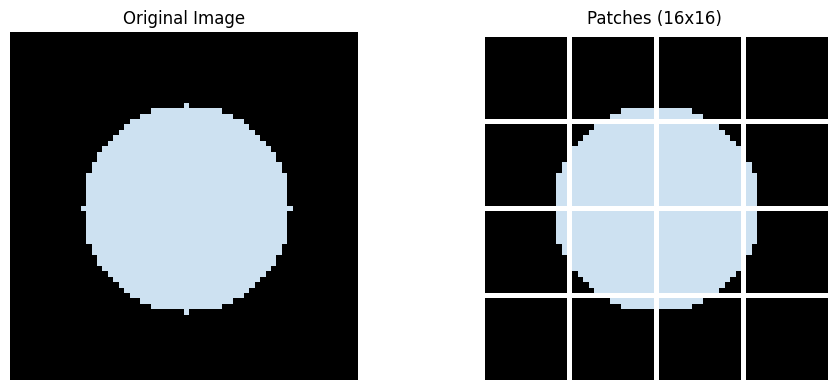

Image divided into 16 patches

4. Showing dataset examples...


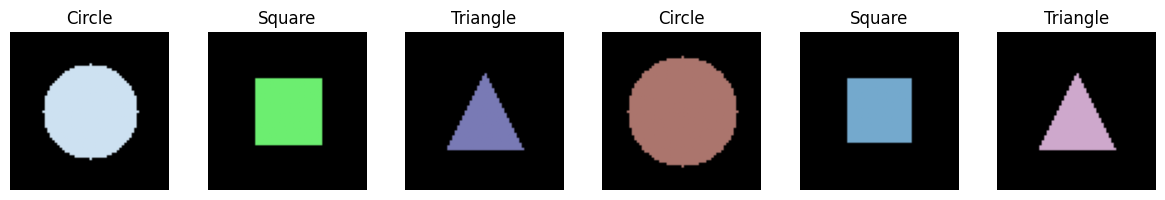


5. Splitting data...
Train: 240, Test: 60

6. Creating Vision Transformer...
ViT model created with 1,152 parameters

7. Training ViT model...
This might take a few minutes...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'simple_vi_t', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.4789 - loss: 1.0819 - val_accuracy: 0.6333 - val_loss: 0.6349
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7778 - loss: 0.5791 - val_accuracy: 0.8667 - val_loss: 0.3602
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8192 - loss: 0.3934 - val_accuracy: 0.8167 - val_loss: 0.3154
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8315 - loss: 0.3447 - val_accuracy: 0.9000 - val_loss: 0.2711
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8682 - loss: 0.2759 - val_accuracy: 0.9167 - val_loss: 0.2433
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8479 - loss: 0.2887 - val_accuracy: 0.9333 - val_loss: 0.2145
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9087 - loss: 0.2865 - val_accuracy: 1.0000 - val_loss: 0.0776
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9778 - loss: 0.0987 - val_accuracy: 1.0000 - val_loss: 0

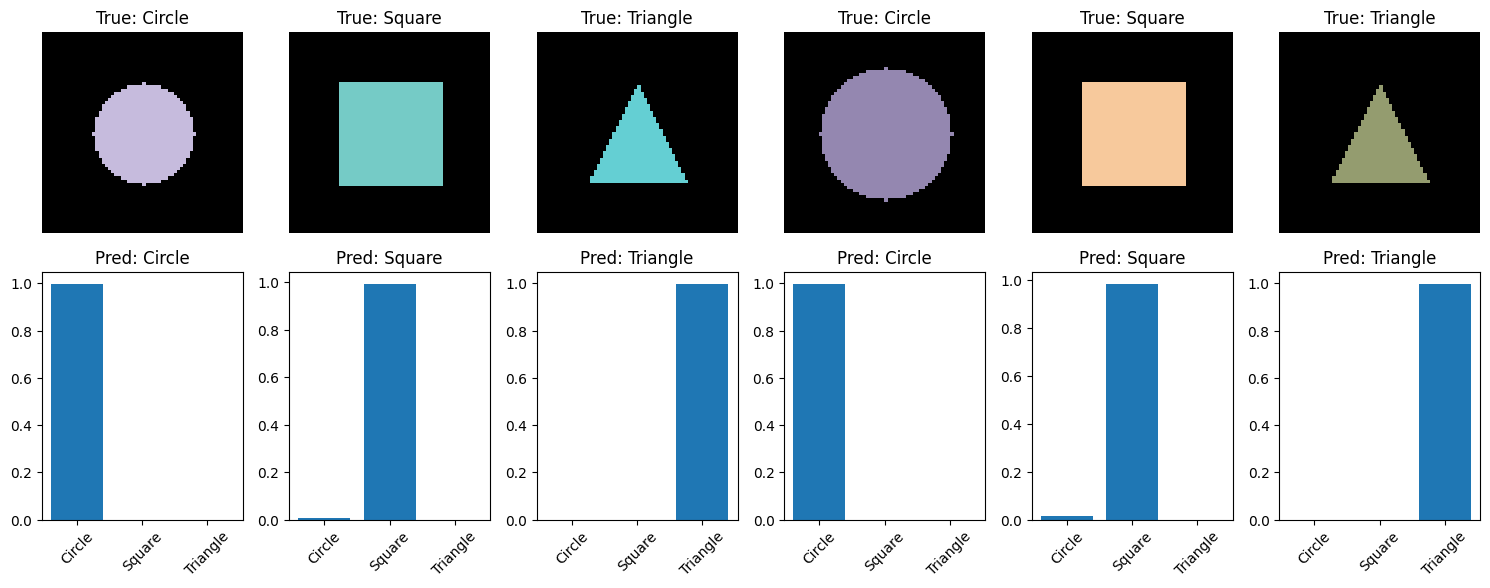


10. Training results...


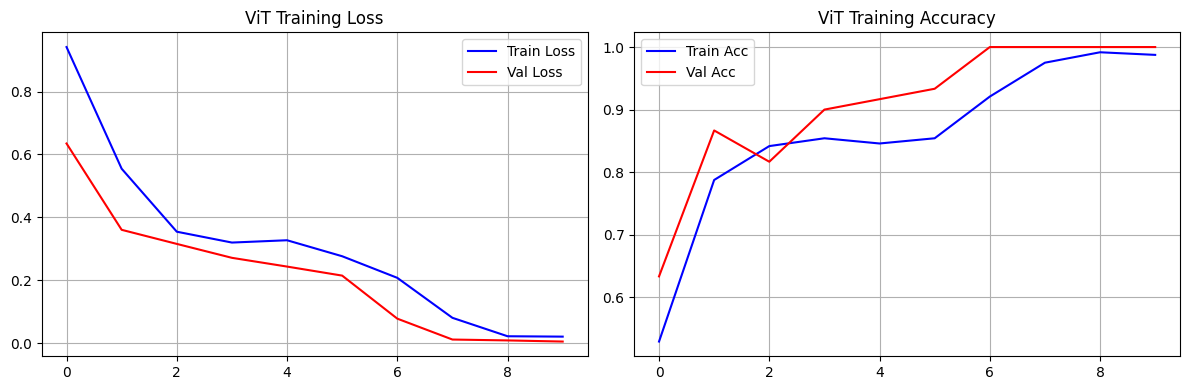


VISION TRANSFORMER EXERCISE COMPLETED! 🎉
What you learned:
✓ How ViT breaks images into patches
✓ Self-attention mechanism for images
✓ Class token for classification
✓ Position embeddings
✓ Complete ViT implementation


In [11]:
run_simple_vit_exercise()